In [5]:
using Images, FileIO, PyPlot

In [43]:
function ddfload(filename)
    # Loads the entire stack of 7 and returns a normalized (0-1) Array{Float64}
    img = load(filename)
    img = Float64.(img)
    img = img .- minimum(img)
    img = img./maximum(img)
    return Float64.(img)
end

function MIP(img)
    img = Float32.(img)
    img = maximum(img, 3)
    img = Float64.(img)
    return img[:, :, 1]
end


function weightedcentroid(focus)
    m = size(focus, 1)
    n = size(focus, 2)

    xsum = sum(focus, 1)
    ysum = sum(focus, 2)
    
    
    weightedsumx = 1*xsum[2]
    for i = 2:n
       weightedsumx = weightedsumx + i*xsum[i] # tack on i*xsum[i]
    end
    
    Cx = weightedsumx/sum(xsum)
    
    weightedsumy = 1*ysum[2]
    
    for i = 2:n
       weightedsumy = weightedsumy + i*ysum[i]
    end
    
    Cy = weightedsumy/sum(ysum)
    
    return (Cx, Cy)
    
end

function makenewfocus(img, x, y, cx, cy, n)
    xoff = cx - ceil(n/2)
    yoff = cy - ceil(n/2)
    
    case1 = (xoff >= 0) & (yoff >= 0)# both positive
    case2 = (xoff >= 0) & (yoff <= 0)# x pos; y neg
    case3 = (xoff <= 0) & (yoff <= 0)# both neg
    case4 = (xoff <= 0) & (yoff >= 0)# x neg; y pos
    r = (n-1)/2
    
    # check if only one case is true
    

    if case1 # both pos
        xstart = x - r
        xfinish = x + r + round(xoff)
        ystart = y - r
        yfinish = y + r + round(yoff)
    end
    
    if case2 # x pos; y neg
        xstart = x - r
        xfinish = x + r + round(xoff)
        ystart = y - r - round(yoff)
        yfinish = y + r
    end
    
    if case3 # both neg
        xstart = x - r - round(xoff)
        xfinish = x + r
        ystart = y - r - round(xoff)
        yfinish = y + r
    end
    
    if case4 # x neg; y pos
        xstart = x - r - round(xoff)
        xfinish = x + r
        ystart = y - r
        yfinish = y + r + round(yoff)
    end

    xstart = Int16.(xstart)
    xfinish = Int16.(xfinish)
    ystart = Int16.(ystart)
    yfinish = Int16.(yfinish)
    
    return img[xstart:xfinish, ystart:yfinish], xoff, yoff



end

function generateidealgaussian(m, n, spread, z, Cx, Cy)
    sigmax = spread
    sigmay = spread
    m = z*m
    n = z*n
    x0 = z*Cx
    y0 = z*Cy

    gauss = zeros(m, n)
    
    for x = 1:m

        for y = 1:n
            a = ((x-x0)^2)/(2*sigmax^2)
            b = ((y-y0)^2)/(2*sigmay^2)
            gauss[x, y] = exp(-( (a) + (b) ))
        end
    end
    
    
    # Normalize
#     gauss = gauss - minimum(gauss)
#     gauss = gauss./maximum(gauss)
    return Float64.(gauss)
end

function discretizegaussian(G, m, n, z)
    # return m x n to be overlaid
    # for now use averaging
    
    Gdiscrete = zeros(m, n)
    
    for x = 1:m
        for y = 1:n
            
            
            
            mstart = 1 + z*(x-1)
            mend = x*z
            nstart = 1 + z*(y-1)
            nend = y*z

            chunk = G[mstart:mend, nstart:nend]
            if x == 3 & y == 1
               singlechunk = chunk
            end
            
            Gdiscrete[x, y] = sum(chunk) / (length(chunk))
            
        end
    end

    return Gdiscrete
end



function isgauss(img, x, y, idealgaussian)
    # Check whether the foci meets using method of SSD
    # Compare it to a n x n 2D gaussian 
    # integral of (I1(i, j) - Gaussian(i, j)^2
    
end

function analyzefocus(img, x, y, n, thresh)
    r = round(Int16.((n-1)/2))
    focus = img[x-r:x+r, y-r:y+r]

    if sum(focus) < thresh # If it didn't make the threshold
        newfocus = false
        Cx = false
        Cy = false
    else # If it did, get the weighted centroid then make the new box
        (Cx, Cy) = weightedcentroid(focus)
        newfocus, Xoff, Yoff = makenewfocus(img, x, y, Cx, Cy, n)
    end
    
    
    return newfocus, Cx, Cy

end

# Try out different score heuristics here

function comparetogaussian(newfocus, Cx, Cy, z, spread)
    # Generate a m x n gaussian 
    spread = z*2
    score = 0
   
    if newfocus != false && Cx != false
        (m, n) = size(newfocus)
                
        G = generateidealgaussian(m, n, spread, z, Cx, Cy)
        G = G 
        # Make amplitude equal to max of focus
        Gdiscrete = discretizegaussian(G, m, n, z)
        if size(Gdiscrete) != size(newfocus)
          score = 0 
        else
            score = sum((Gdiscrete .- newfocus)^2)
        end

    end 
    
    return score
end

function stdscore(newfocus)
    if newfocus != false
        return std(vec(newfocus))
    else
        return 0
    end
end

function centerminuscorner(newfocus)
    if newfocus != false
        return newfocus[3, 3] - (1/4)*(newfocus[1, 1] + newfocus[size(newfocus, 1), 1] + newfocus[1, size(newfocus, 2)] + newfocus[size(newfocus, 1), size(newfocus, 2)])
    else
        return 0
    end
end

function centerovercorner(newfocus)
    if newfocus != false
        return newfocus[3, 3] / (1/4)*(newfocus[1, 1] + newfocus[size(newfocus, 1), 1] + newfocus[1, size(newfocus, 2)] + newfocus[size(newfocus, 1), size(newfocus, 2)])
    else
        return 0
    end
end

centerovercorner (generic function with 1 method)

In [44]:
function main(file)
    # Load and do a MIP
    img = ddfload(file) 
    img = MIP(img)

    n = 5 # kernel size
    z = 10 # resolution of gaussian
    r = Int16.((n-1)/2)
    
    poss = 0
    count = 0
    
    thresh = 1.5
    
    # Have to start at [3, 3] for a 5x5 kernel 
    xstart = round((n/2)+1)
    xend = size(img, 1) - xstart
    ystart = round((n/2)+1)
    yend = size(img, 2) - ystart
    xstart = Int16.(xstart)
    xend = Int16.(xend)
    ystart = Int16.(ystart)
    yend = Int16.(yend)


    scores = zeros(size(img))
    stdev = zeros(size(img))
    
    for x = xstart:xend
        for y = ystart:yend
    
            focus = img[x-r:x+r,y-r:y+r]
            stdev[x, y] = std(vec(focus))
            
            count = count + 1
            
            # Returns false if the potential focus gets pruned (rn this is with a simple threshold)
            newbox, Cx, Cy = analyzefocus(img, x, y, n, thresh)
            
            # This is where we actualy score it using one of the heuristics at the end of the previous cell
            spread = 100
            
            scores[x, y] = centerminuscorner(newbox)       
            
        end
    end
    
    fig = figure("pyplot_subplot_mixed",figsize=(18, 10)) # Create a new blank figure
    subplot(121)
    title("Original Image")
    PyPlot.imshow(img)
    suptitle("Image Intensities")
    
    subplot(122) # Create the second plot of a 3x1 group of subplots
    title("Scored pixels")
    PyPlot.imshow(scores)
end

main (generic function with 1 method)

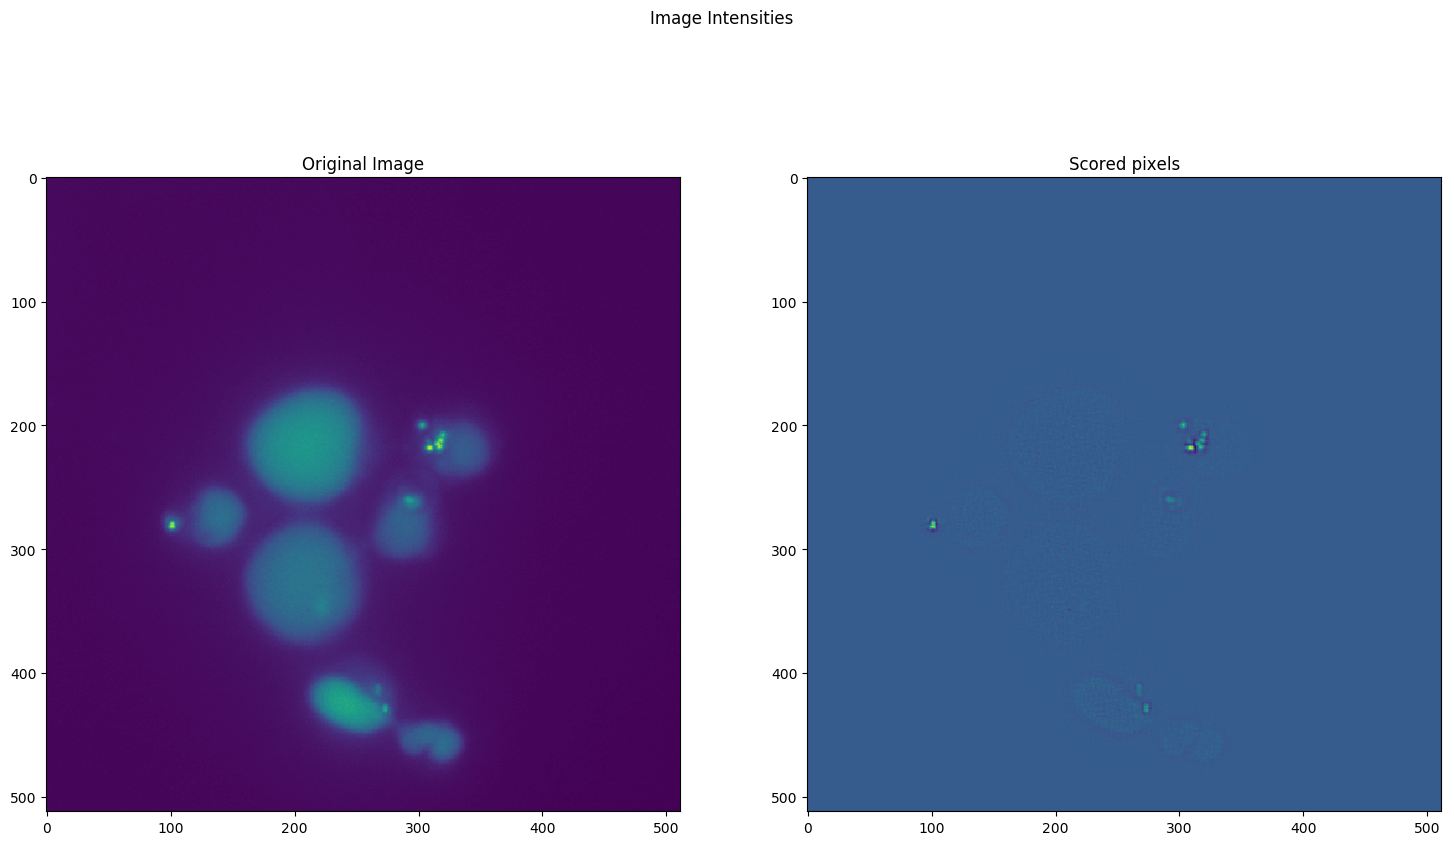

PyObject <matplotlib.image.AxesImage object at 0x12de6aa90>

In [46]:
main("GFP_003.tif")

#PyPlot.imshow(im.>0.7) to threshold
# PyPlot.imshow(MIP(ddfload("RFP_003.tif")))

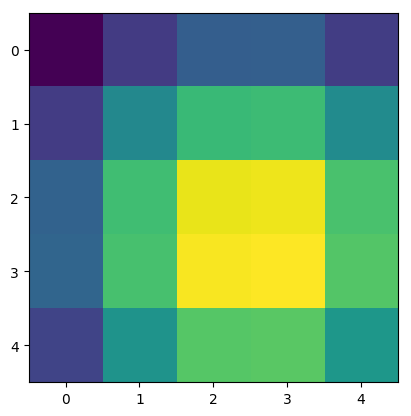

PyObject <matplotlib.image.AxesImage object at 0x129a20c10>

In [37]:
(m, n) = size(newbox)
z = 100
Gideal = discretizegaussian(generateidealgaussian(m, n, 2*z, z, Cx, Cy), m, n, z)

PyPlot.imshow(Gideal)